<a href="https://colab.research.google.com/github/diskualified/deeplearning/blob/main/Copy_of_AIT_09_Author_classification_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [157]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv1D, MaxPooling1D, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from urllib.request import urlretrieve
import numpy as np
import random
import sys
import re, cgi

## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

In [158]:
url_pandp="https://www.gutenberg.org/cache/epub/1342/pg1342.txt"
urlretrieve(url_pandp, 'pandp.txt')
pandp = open("pandp.txt", encoding='utf-8').read().lower()

url_little_women="https://www.gutenberg.org/cache/epub/37106/pg37106.txt"
urlretrieve(url_little_women, 'little_women.txt')
little_women = open("little_women.txt", encoding='utf-8').read().lower()

## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

In [159]:
print('Number of characters in Pride and Prejudice:', len(pandp))
print('Number of characters in Little Women:', len(little_women))

Number of characters in Pride and Prejudice: 748079
Number of characters in Little Women: 1100128


<BarContainer object of 2 artists>

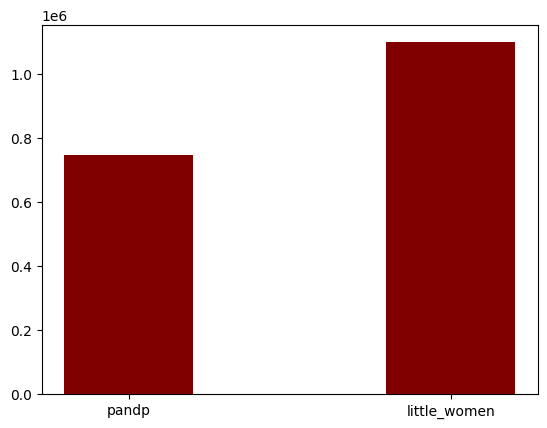

In [160]:
import matplotlib.pyplot as plt
data = {"pandp" : len(pandp), "little_women" : len(little_women)}
plt.bar(data.keys(), data.values(), color ='maroon', width = 0.4)

## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [161]:
pandpchar = sorted(list(set(pandp)))
lwchar = sorted(list(set(little_women)))
print(len(pandpchar))
print(len(lwchar))

72
77


In [162]:
ppchar_indices = dict((c, i) for i, c in enumerate(pandpchar))
ppindices_char = dict((i, c) for i, c in enumerate(pandpchar))

print ("Indices to char dictionary:", ppindices_char)

Indices to char dictionary: {0: '\n', 1: ' ', 2: '!', 3: '"', 4: '#', 5: '$', 6: '%', 7: '&', 8: "'", 9: '(', 10: ')', 11: '*', 12: ',', 13: '-', 14: '.', 15: '/', 16: '0', 17: '1', 18: '2', 19: '3', 20: '4', 21: '5', 22: '6', 23: '7', 24: '8', 25: '9', 26: ':', 27: ';', 28: '?', 29: '[', 30: ']', 31: '^', 32: '_', 33: 'a', 34: 'b', 35: 'c', 36: 'd', 37: 'e', 38: 'f', 39: 'g', 40: 'h', 41: 'i', 42: 'j', 43: 'k', 44: 'l', 45: 'm', 46: 'n', 47: 'o', 48: 'p', 49: 'q', 50: 'r', 51: 's', 52: 't', 53: 'u', 54: 'v', 55: 'w', 56: 'x', 57: 'y', 58: 'z', 59: '{', 60: '}', 61: '·', 62: 'à', 63: 'â', 64: 'é', 65: 'ê', 66: 'œ', 67: '‘', 68: '’', 69: '“', 70: '”', 71: '\ufeff'}


In [163]:
lwchar_indices = dict((c, i) for i, c in enumerate(lwchar))
lwindices_char = dict((i, c) for i, c in enumerate(lwchar))

print ("Indices to char dictionary:", lwindices_char)

Indices to char dictionary: {0: '\n', 1: ' ', 2: '!', 3: '"', 4: '#', 5: '$', 6: '%', 7: '&', 8: "'", 9: '(', 10: ')', 11: '*', 12: ',', 13: '-', 14: '.', 15: '/', 16: '0', 17: '1', 18: '2', 19: '3', 20: '4', 21: '5', 22: '6', 23: '7', 24: '8', 25: '9', 26: ':', 27: ';', 28: '=', 29: '?', 30: '@', 31: '[', 32: ']', 33: '_', 34: 'a', 35: 'b', 36: 'c', 37: 'd', 38: 'e', 39: 'f', 40: 'g', 41: 'h', 42: 'i', 43: 'j', 44: 'k', 45: 'l', 46: 'm', 47: 'n', 48: 'o', 49: 'p', 50: 'q', 51: 'r', 52: 's', 53: 't', 54: 'u', 55: 'v', 56: 'w', 57: 'x', 58: 'y', 59: 'z', 60: '{', 61: '\xa0', 62: 'à', 63: 'â', 64: 'ä', 65: 'æ', 66: 'ç', 67: 'è', 68: 'é', 69: 'ê', 70: 'ë', 71: 'ö', 72: 'ü', 73: 'œ', 74: '•', 75: '™', 76: '\ufeff'}


In [164]:
combined_char_indices = (lwchar_indices| ppchar_indices)

In [165]:
seq_len = 60
step = 60
ppsentences = []
lwsentences = []

In [166]:
for i in range(0, len(pandp)-seq_len, step):
    ppsentences.append(pandp[i:i+seq_len])
for i in range(0, len(little_women)-seq_len, step):
    lwsentences.append(little_women[i:i+seq_len])
totallen = len(ppsentences) + len(lwsentences)

In [167]:
# X is sequences by character
X = np.zeros((totallen, seq_len, len(combined_char_indices)), dtype =float)
# y is 0 or 1 based on author
y = np.zeros((totallen,2), dtype=float)

In [168]:
for i, sentence in enumerate(ppsentences):
    for t, char in enumerate(sentence): 
        X[i,t,combined_char_indices[char]] = 1
    y[i][0] = 1

for i, sentence in enumerate(lwsentences):
    for t, char in enumerate(sentence): 
        X[i+len(ppsentences),t,combined_char_indices[char]] = 1
    y[i+len(ppsentences)][1] = 1

print ("Shape of the input data:", X.shape)
print ("Shape of the target data:", y.shape)

Shape of the input data: (30802, 60, 84)
Shape of the target data: (30802, 2)


## Data splitting
Split the data into train, validate and test sets. Make 

In [169]:
pplen = len(ppsentences)
lwlen = len(lwsentences)
print(pplen)
print(lwlen)

12467
18335


In [170]:
train_ratio = 0.8
validate_ratio = 0.1
test_ratio = 0.1

pptrain_split = int(train_ratio * pplen)
ppvalid_split = pptrain_split + int(validate_ratio * pplen)

lwtrain_split = pplen + int(train_ratio * lwlen)
lwvalid_split = lwtrain_split + int(validate_ratio * lwlen)

X_train = np.concatenate((X[:pptrain_split], X[pplen:lwtrain_split]), axis=0)
X_valid = np.concatenate((X[pptrain_split:ppvalid_split], X[lwtrain_split:lwvalid_split]), axis=0) 
X_test = np.concatenate((X[ppvalid_split:pplen], X[lwvalid_split:]), axis=0)

Y_train = np.concatenate((y[:pptrain_split], y[pplen:lwtrain_split]), axis=0)
Y_valid = np.concatenate((y[pptrain_split:ppvalid_split], y[lwtrain_split:lwvalid_split]), axis=0)
Y_test = np.concatenate((y[ppvalid_split:pplen], y[lwvalid_split:]), axis=0)



## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [171]:
nb_filter       = 32   # number of filter/kernels in the convolutional layers
filter_length   = 3  # length of the filter/kernel in the convolutional layers
window_size     = X_train.shape[1] # the window size defined by the dataset
nb_features     = X_train.shape[2] # the number of features of the input data
nb_outputs      = Y_train.shape[1] # the number of outputs (defined by the target data)

In [172]:
model = Sequential()
model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal', input_shape=(window_size, nb_features)))
model.add(MaxPooling1D())
model.add(Dropout(0.3))
model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal'))
model.add(MaxPooling1D())
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(nb_outputs, activation='sigmoid'))

In [173]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [174]:
es = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")

## Model training
Train the model and apply early stopping.

In [175]:
model.fit(X_train, Y_train, 
          epochs=50, batch_size=32, 
          # validation_split=0.2, # don't change the validation split
          validation_data=(X_valid,Y_valid),
          callbacks=[es],
          verbose=2)

Epoch 1/50
771/771 - 6s - loss: 0.5218 - accuracy: 0.7120 - val_loss: 0.4180 - val_accuracy: 0.7736 - 6s/epoch - 7ms/step
Epoch 2/50
771/771 - 3s - loss: 0.3636 - accuracy: 0.8181 - val_loss: 0.3673 - val_accuracy: 0.8120 - 3s/epoch - 4ms/step
Epoch 3/50
771/771 - 4s - loss: 0.3340 - accuracy: 0.8364 - val_loss: 0.3563 - val_accuracy: 0.8184 - 4s/epoch - 5ms/step
Epoch 4/50
771/771 - 3s - loss: 0.3149 - accuracy: 0.8520 - val_loss: 0.3504 - val_accuracy: 0.8220 - 3s/epoch - 4ms/step
Epoch 5/50
771/771 - 3s - loss: 0.3083 - accuracy: 0.8508 - val_loss: 0.3391 - val_accuracy: 0.8279 - 3s/epoch - 4ms/step
Epoch 6/50
771/771 - 3s - loss: 0.2985 - accuracy: 0.8588 - val_loss: 0.3352 - val_accuracy: 0.8204 - 3s/epoch - 4ms/step
Epoch 7/50
771/771 - 4s - loss: 0.2944 - accuracy: 0.8593 - val_loss: 0.3451 - val_accuracy: 0.8311 - 4s/epoch - 6ms/step
Epoch 8/50
771/771 - 3s - loss: 0.2876 - accuracy: 0.8638 - val_loss: 0.3253 - val_accuracy: 0.8363 - 3s/epoch - 4ms/step
Epoch 9/50
771/771 - 3s 

## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [176]:
eval = model.evaluate(X_test,Y_test)
print("Test loss:",eval[0])
print("Test accuracy:",eval[1])

97/97 [==============================] - 0s 4ms/step - loss: 0.4496 - accuracy: 0.8050
Test loss: 0.44957420229911804
Test accuracy: 0.8049967288970947


## Confusion matrix
Calculate and display the confusion matrix.

97/97 [==============================] - 1s 5ms/step


<Axes: >

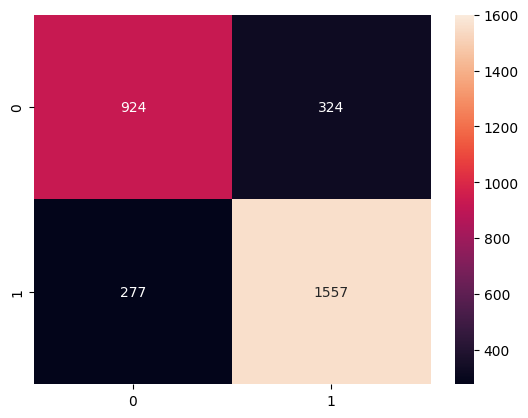

In [179]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

preds = model.predict(X_test)
conf=confusion_matrix(np.argmax(Y_test,1),np.argmax(preds,1))
sns.heatmap(conf, annot=True, fmt='d', vmax=1600)

In [178]:
print(classification_report(np.argmax(Y_test,1),np.argmax(preds,1)))


              precision    recall  f1-score   support

           0       0.77      0.74      0.75      1248
           1       0.83      0.85      0.84      1834

    accuracy                           0.80      3082
   macro avg       0.80      0.79      0.80      3082
weighted avg       0.80      0.80      0.80      3082

